In [4]:
# 📦 Install dependencies if not already installed
!pip -q install sentence-transformers fastembed qdrant-client torch

In [44]:
from qdrant_client import QdrantClient, models
import json

client = QdrantClient(host="localhost", port=6333)
point = client.retrieve(collection_name="movies", ids=[123], with_payload=True, with_vectors=True)
print(point)
print(json.dumps(point[0].payload, indent=4))

[Record(id=123, payload={'user_id': 1, 'title': 'Gravity', 'overview': 'Dr. Ryan Stone, a brilliant medical engineer on her first Shuttle mission, with veteran astronaut Matt Kowalsky in command of his last flight before retiring. But on a seemingly routine spacewalk, disaster strikes. The Shuttle is destroyed, leaving Stone and Kowalsky completely alone-tethered to nothing but each other and spiraling out into the blackness of space. The deafening silence tells them they have lost any link to Earth and any chance for rescue. As fear turns to panic, every gulp of air eats away at what little oxygen is left. But the only way home may be to go further out into the terrifying expanse of space.'}, vector={'dense': [-0.009726355, -0.052597698, 0.03330454, 0.04060429, 0.0071809255, 0.024255417, 0.08473428, -0.027259327, 0.11358667, -0.033618078, 0.0068421275, 0.0395244, -0.10274127, 0.07393896, -0.110578634, -0.013316169, 0.062280923, 0.030652285, -0.073899485, 0.04584539, -0.024542231, 0.08

In [76]:
from qdrant_client import QdrantClient, models
from sentence_transformers import SentenceTransformer
from fastembed.sparse import SparseTextEmbedding
import torch

# Connect & load models
client = QdrantClient(host="localhost", port=6333)
dense_model = SentenceTransformer("all-MiniLM-L6-v2").eval()
sparse_model = SparseTextEmbedding(
    model_name="Qdrant/bm42-all-minilm-l6-v2-attentions",  # same as during upload
    providers=["CPUExecutionProvider"],
    quantize=True
)

def hybrid_search(query: str, user_id: int, top_k: int = 5):
    # Dense embedding
    dense_vec = dense_model.encode(query).tolist()

    # Sparse embedding
    sparse_embedding = next(sparse_model.embed(query))
    sparse_vec = models.SparseVector(
        indices=sparse_embedding.indices.tolist(),
        values=sparse_embedding.values.tolist()
    )

    # Batch search requests
    requests = [
        models.SearchRequest(
            vector=models.NamedVector(name="dense", vector=dense_vec),
            filter=models.Filter(
                must=[models.FieldCondition(key="user_id", match=models.MatchAny(any=user_ids),)]
            ),
            limit=top_k,
            with_payload=["title", "overview"]
        ),
        models.SearchRequest(
            vector=models.NamedSparseVector(name="sparse", vector=sparse_vec),
            filter=models.Filter(
                must=[models.FieldCondition(key="user_id", match=models.MatchAny(any=user_ids),)]
            ),
            limit=top_k,
            with_payload=["title", "overview"]
        )
    ]

    # Search both vectors
    results = client.search_batch(collection_name="movies", requests=requests)
    return results


In [50]:
from fastembed.rerank.cross_encoder import TextCrossEncoder
import time

# Load reranker
reranker = TextCrossEncoder(model_name="jinaai/jina-reranker-v2-base-multilingual")

# 🔁 Reciprocal Rank Fusion (RRF)
def reciprocal_rank_fusion(results_list: list, k: int = 60):
    fused_scores = {}
    all_hits = {}

    for results in results_list:
        for rank, hit in enumerate(results, 1):
            if not hit.payload or "title" not in hit.payload:
                continue
            if hit.id not in fused_scores:
                fused_scores[hit.id] = 0.0
                all_hits[hit.id] = hit
            fused_scores[hit.id] += 1.0 / (rank + k)

    sorted_hits = sorted(all_hits.values(), key=lambda x: fused_scores[x.id], reverse=True)
    return sorted_hits

# 🧠 Full rerank pipeline with latency
def hybrid_reranked_search(query: str, user_id: int, top_k=20, rerank_top_n=5):
    start = time.time()

    dense_results, sparse_results = hybrid_search(query, user_id, top_k=top_k)

    fused = reciprocal_rank_fusion([dense_results, sparse_results])
    rerank_candidates = fused[:rerank_top_n]

    documents = [hit.payload["title"] + " " + hit.payload["overview"] for hit in rerank_candidates]
    scores = reranker.rerank(query=query, documents=documents, k=rerank_top_n)

    reranked = sorted(
        zip(rerank_candidates, scores),
        key=lambda x: x[1],
        reverse=True
    )

    end = time.time()
    print(f"⏱️ Latency: {end - start:.2f}s | Query: \"{query}\"")

    return reranked

In [80]:
# user_ids = list(range(1, 11))
user_ids = [1,2,3]
print(user_ids)

[1, 2, 3]


In [82]:
query = "The adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage"
user_ids = list(range(1, 11))
# user_ids = [1,2,3]

dense_results, sparse_results = hybrid_search(query, user_id)

print("Dense results:")
for hit in dense_results[:5]:
    print(f"- {hit.payload['title']} ({hit.score:.4f})")

print("\nSparse results:")
for hit in sparse_results[:5]:
    print(f"- {hit.payload['title']} ({hit.score:.4f})")

results = hybrid_reranked_search(query, user_id)

print("\nTop Reranked Results:")
for i, (hit, score) in enumerate(results, 1):
    print(f"{i}. {hit.payload['title']} (Score: {score:.4f})")


/tmp/ipykernel_192356/919370111.py:47: DeprecationWarning: `search_batch` method is deprecated and will be removed in the future. Use `query_batch_points` instead.
  results = client.search_batch(collection_name="movies", requests=requests)


Dense results:
- Interstellar (0.8289)
- Greetings From Wormhole 61 (0.6731)
- Atlas (0.6575)
- wormhole (void) (0.6574)
- The Expedition to the End of the World (0.6439)

Sparse results:
- Interstellar (0.3891)
- In Space with Markiplier: Part 2 (0.1747)
- Greetings From Wormhole 61 (0.1680)
- wormhole (void) (0.1619)
- The Beyond (0.1613)
⏱️ Latency: 5.79s | Query: "The adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage"

Top Reranked Results:
1. Interstellar (Score: 2.0271)
2. The Beyond (Score: 0.2998)
3. The Spaceman (Score: -0.3467)
4. Greetings From Wormhole 61 (Score: -0.7371)
5. wormhole (void) (Score: -1.6124)


In [28]:
import json
import random
import time
from pathlib import Path

# 🔧 Configuration
QUERY_SET = [
    "space survival after disaster",
    "future war with robots",
    "romantic comedy set in New York",
    "a detective solving mysterious murders",
    "animated adventure through the jungle",
    "vampires hunting humans at night",
    "time travel gone wrong",
    "fighting for freedom in medieval times",
    "AI becomes sentient and dangerous",
    "epic historical battle scenes"
]

USER_IDS = list(range(1, 11))
TOP_K = 20
RERANK_TOP_N = 10

# 📁 Output log
log_path = Path("query_logs.jsonl")
log_path.write_text("")  # Clear previous logs

# 🚀 Evaluation loop
for i, query in enumerate(QUERY_SET):
    user_id = random.choice(USER_IDS)
    start = time.time()
    
    results = hybrid_reranked_search(query, user_id, top_k=TOP_K, rerank_top_n=RERANK_TOP_N)
    
    elapsed = time.time() - start
    top_titles = [hit.payload["title"] for hit, _ in results]
    top_scores = [score for _, score in results]

    record = {
        "query": query,
        "user_id": user_id,
        "latency_sec": round(elapsed, 3),
        "top_titles": top_titles,
        "rerank_scores": [round(s, 4) for s in top_scores],
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
    }

    # Print + append to log (✅ fixed)
    print(f"✅ [{i+1}/{len(QUERY_SET)}] \"{query}\" | Top: {top_titles[0]} | ⏱️ {elapsed:.2f}s")
    with log_path.open("a") as f:
        f.write(json.dumps(record) + "\n")


/tmp/ipykernel_192356/1074317097.py:47: DeprecationWarning: `search_batch` method is deprecated and will be removed in the future. Use `query_batch_points` instead.
  results = client.search_batch(collection_name="movies", requests=requests)


⏱️ Latency: 1.23s | Query: "space survival after disaster"
✅ [1/10] "space survival after disaster" | Top: Rescue Dawn | ⏱️ 1.23s
⏱️ Latency: 1.47s | Query: "future war with robots"
✅ [2/10] "future war with robots" | Top: WALL·E | ⏱️ 1.47s
⏱️ Latency: 1.16s | Query: "romantic comedy set in New York"
✅ [3/10] "romantic comedy set in New York" | Top: Whatever Works | ⏱️ 1.16s
⏱️ Latency: 1.15s | Query: "a detective solving mysterious murders"
✅ [4/10] "a detective solving mysterious murders" | Top: Murder by Numbers | ⏱️ 1.15s
⏱️ Latency: 1.20s | Query: "animated adventure through the jungle"
✅ [5/10] "animated adventure through the jungle" | Top: Dora and the Lost City of Gold | ⏱️ 1.20s
⏱️ Latency: 1.27s | Query: "vampires hunting humans at night"
✅ [6/10] "vampires hunting humans at night" | Top: Priest | ⏱️ 1.27s
⏱️ Latency: 1.42s | Query: "time travel gone wrong"
✅ [7/10] "time travel gone wrong" | Top: The Tomorrow War | ⏱️ 1.42s
⏱️ Latency: 1.45s | Query: "fighting for freedom in

In [20]:
pip install -q matplotlib pandas

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


/home/ec2-user/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


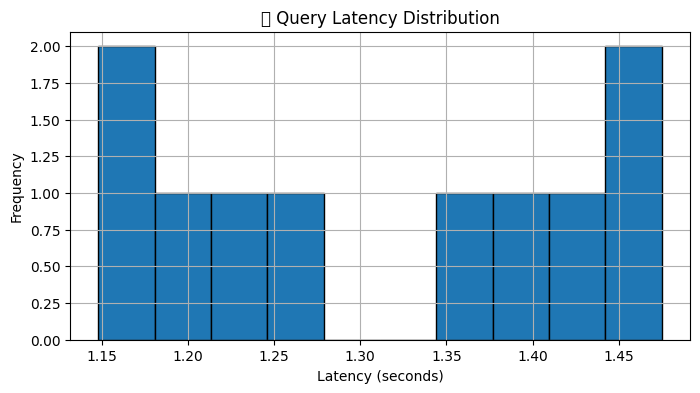

/tmp/ipykernel_192356/2400564521.py:30: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/ec2-user/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


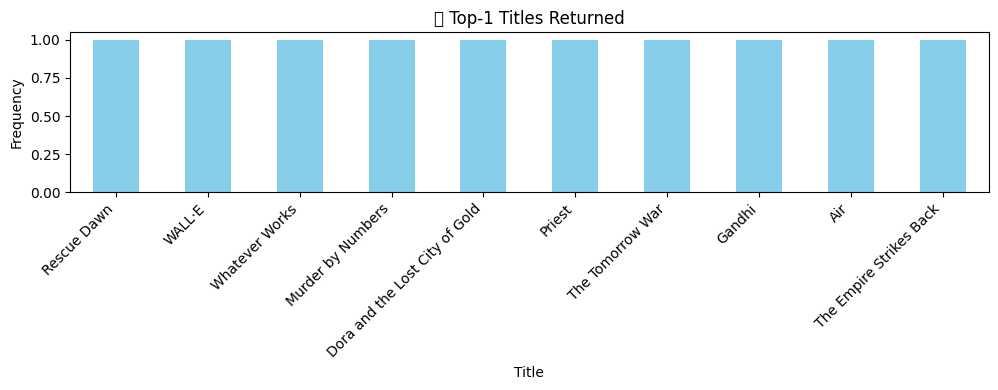

/home/ec2-user/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


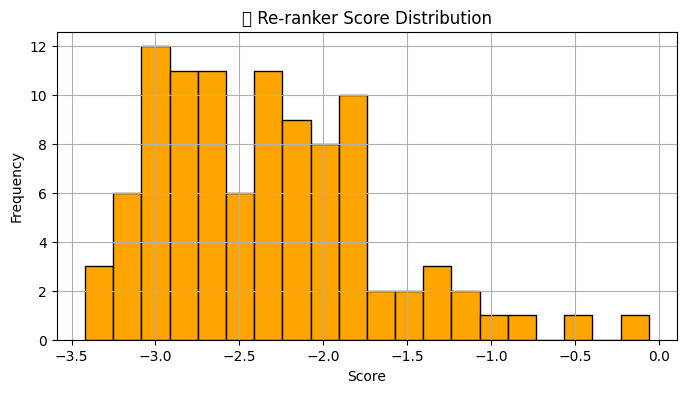

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path

# 📂 Load logs correctly
log_path = Path("query_logs.jsonl")
records = [json.loads(line) for line in log_path.read_text().splitlines()]
df = pd.DataFrame(records)


# 🎯 1. Query Latency
plt.figure(figsize=(8, 4))
plt.hist(df["latency_sec"], bins=10, edgecolor="black")
plt.title("⏱️ Query Latency Distribution")
plt.xlabel("Latency (seconds)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 🎯 2. Top-1 Titles Frequency
top1_counts = df["top_titles"].apply(lambda x: x[0]).value_counts()

plt.figure(figsize=(10, 4))
top1_counts.plot(kind="bar", color="skyblue")
plt.title("🏆 Top-1 Titles Returned")
plt.xlabel("Title")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 🎯 3. Re-ranker Scores Distribution
all_scores = [score for scores in df["rerank_scores"] for score in scores]

plt.figure(figsize=(8, 4))
plt.hist(all_scores, bins=20, edgecolor="black", color="orange")
plt.title("📈 Re-ranker Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [29]:
# Check the first few lines manually
log_path = Path("query_logs.jsonl")
for i, line in enumerate(log_path.read_text().splitlines()):
    print(f"Line {i}: {line}")
    try:
        json.loads(line)
    except json.JSONDecodeError as e:
        print(f"❌ JSON error on line {i}: {e}")
        break


Line 0: {"query": "space survival after disaster", "user_id": 8, "latency_sec": 1.232, "top_titles": ["Rescue Dawn", "Space Cowboys", "Riddick", "Alien", "Vesper", "Lone Survivor", "Explorers", "Tidal Wave", "Saw 3D", "BURN\u00b7E"], "rerank_scores": [-2.0004, -2.2028, -2.3331, -2.3648, -2.3834, -2.7892, -2.831, -2.9263, -3.0668, -3.1325], "timestamp": "2025-03-24 23:35:19"}
Line 1: {"query": "future war with robots", "user_id": 6, "latency_sec": 1.475, "top_titles": ["WALL\u00b7E", "ARQ", "WarGames", "A.I. Artificial Intelligence", "Big Hero 6", "Captain America: Civil War", "War Machine", "Justice League Dark: Apokolips War", "Son of Rambow", "Bumblebee"], "rerank_scores": [-1.145, -1.98, -2.0459, -2.1564, -2.2844, -2.3894, -2.3915, -2.7874, -2.9872, -3.0834], "timestamp": "2025-03-24 23:35:21"}
Line 2: {"query": "romantic comedy set in New York", "user_id": 4, "latency_sec": 1.162, "top_titles": ["Whatever Works", "Marriage Story", "Date Movie", "More the Merrier", "The Nanny Diarie

In [ ]:
from importlib import reload
import src.config
from qdrant_client import QdrantClient  # Import QdrantClient

# Reload the config module to ensure the latest config.yaml is used
reload(src.config)
config = src.config.load_config()

# Test the new Qdrant connection
try:
    _qdrant = QdrantClient(
        host=config["qdrant"]["host"],
        port=config["qdrant"]["port"],
        timeout=config["qdrant"].get("timeout", 60.0)
    )
    print(f"✅ Connected to Qdrant at {config['qdrant']['host']}:{config['qdrant']['port']}")
except Exception as e:
    print(f"❌ Failed to connect to Qdrant: {e}")